# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.feature_selection import RFE

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


# Predicting Churn with Logistic Regression
In order to predict the CHURN_IND, a Logistic Model will be appropriate. This is because CHURN_IND is a categorical variable (assuming 1 means the customer has churned, and 0 means the customer has not churned). 
This model will be produced following a series of steps:
1. Cleaning the data and converting string/categorical data into numerical/binary data 
2. Splitting the data into training and testing sections
3. Creating and training a Logistic Regression Model
4. Evaluating the accuracy of the Logistic Regression Model
5. Performing recursive feature elemination to see which features have the most/least effect on CHURN_IND

## Cleaning the Data
The churn data is a mix of categorical and numerical data. In order to create the Logistic Regression model, we need the data to be all numerical. To solve this problem I will be using the method of "One Hot Encoding" (or pd.get_dummies) to convert the categorical data into numerical (binary) data. This will take each category in a column and split it across multiple columns (one for each category). These columns will then either contain 1 (if that row is equal to the category) or 0 (if that row is not equal to the category). For example the "STATE" column contains the values NSW,QLD,VIC..., this process will split this column up into a column called NSW, a column called QLD, a column called VIC and so on. If the row has the value NSW, the NSW column will contain a 1, and the other columns will contain a 0. 

In [3]:
churnAnalysis = churn.drop(["CFU", "BYO_PLAN_STATUS", "CONTRACT_STATUS", "CUST_ID", "COUNTRY_METRO_REGION", "STATE", "RECON_TELE_NEXT_MTH", "RECON_EMAIL_NEXT_MTH", "RECON_SMS_NEXT_MTH", "HANDSET_USED_BRAND"], axis=1)


In [4]:
chunrnAnalysis = churnAnalysis.dropna(how='any', inplace=True)
churnAnalysis = churnAnalysis.join(pd.get_dummies(churn["HANDSET_USED_BRAND"], dummy_na=False))
churnAnalysis = churnAnalysis.join(pd.get_dummies(churn["CONTRACT_STATUS"], dummy_na=False))
churnAnalysis = churnAnalysis.join(pd.get_dummies(churn["CFU"], dummy_na=False))
churnAnalysis = churnAnalysis.join(pd.get_dummies(churn["BYO_PLAN_STATUS"], dummy_na=False))
churnAnalysis = churnAnalysis.join(pd.get_dummies(churn["COUNTRY_METRO_REGION"], dummy_na=False))
churnAnalysis = churnAnalysis.join(pd.get_dummies(churn["STATE"], dummy_na=False))

## Train Test Split
In order to properly train the model and then test to see if it can accurately predict churn, I will split the data up randomly. 80% of the data will make up the training data in which the model will learn what values influence the CHURN_IND value. The other 20% of the data will have the CHURN_IND column taken off, then run through the model which will attempt to predict was the CHURN_IND is. A comparison between the predicted CHURN_IND and the actual CHURN_IND of the testing data will give a good indication of how accurate the model is. 

In [5]:
train, test = train_test_split(churnAnalysis, test_size=0.2, random_state = 100)
print(train.shape)
print(test.shape)

(36904, 34)
(9226, 34)


In [6]:
X_train = train.drop(['CHURN_IND'], axis=1)
y_train = train['CHURN_IND']
X_test = test.drop(['CHURN_IND'], axis=1)
y_test = test['CHURN_IND']


lr = LogisticRegression()
lr.fit(X_train, y_train)

C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

In [8]:
print("Train Accuracy: ")
print(accuracy_score(y_train, train_preds))
print("Test Accuracy: ")
print(accuracy_score(y_test, test_preds))

Train Accuracy: 
0.7234988077173207
Test Accuracy: 
0.7233904183828311


Train Confusion Matrix: 


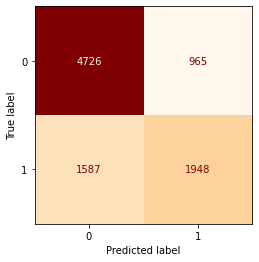

In [9]:
print("Train Confusion Matrix: ")
plot_confusion_matrix(lr, X_test, y_test, cmap="OrRd", colorbar = False)

### Accuracy Summary
As seen above the model had a train accuracy (the accuracy of the model when looking at its own data) of 0.7234. It also had a test accuracy (the accuracy of the model when looking at data it has not seen) of 0.7233. Additionally, the confusion matrix shows that the mode is quite good at predicting when CHURN_IND is 0, but not as good when predicting if CHURN_IND is 1. 

## Recursive Feature Elimination
Our model contains a lot of different variables that will influence the accuracy of the output. In order to get a better idea of what features influence the model, I will create a recursive feature elimination model that will test the importance of each feature in the model. This will leave us with a ranking of the most important features in the model. 

In [10]:
lr = LogisticRegression()
rfe = RFE(estimator = lr, n_features_to_select = 1, step=1)
rfe.fit(X_train, y_train)

C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\liamf\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [11]:
featureRanking = pd.DataFrame(X_train.columns, columns=['Features'])
featureRanking = featureRanking.join(pd.DataFrame(rfe.ranking_, columns=['Rank']))
featureRanking = featureRanking.sort_values(by=['Rank'])
print("The features in order of importance to the model are as follows: ")
print(str(featureRanking.values))

The features in order of importance to the model are as follows: 
[['ON-CONTRACT' 1]
 ['UNKNOWN' 2]
 ['BYO' 3]
 ['COUNTRY' 4]
 ['CONSUMER' 5]
 ['GOOGLE' 6]
 ['OFF-CONTRACT' 7]
 ['NO-CONTRACT' 8]
 ['NON BYO' 9]
 ['OTHER' 10]
 ['ACT' 11]
 ['WA' 12]
 ['QLD' 13]
 ['ACCT_CNT_SERVICES' 14]
 ['APPLE' 15]
 ['SAMSUNG' 16]
 ['MONTHS_OF_CONTRACT_REMAINING' 17]
 ['NSW' 18]
 ['AGE' 19]
 ['ACCOUNT_TENURE' 20]
 ['PREV_CONTRACT_DURATION' 21]
 ['SA' 22]
 ['MONTHLY_SPEND' 23]
 ['METRO' 24]
 ['LAST_FX_CONTRACT_DURATION' 25]
 ['TAS' 26]
 ['SMALL BUSINESS' 27]
 ['PLAN_TENURE' 28]
 ['SERVICE_TENURE' 29]
 ['VIC' 30]
 ['PLAN_ACCESS_FEE' 31]
 ['HUAWEI' 32]
 ['NT' 33]]


# SUMMARY
My model can predict whether a customer will churn or not with a 72% accuracy. The differnece in accuracy between the train and test sets for the model were negligable, this indicates that the model had low levels of over-fitting and will likely maintain its accuracy with new unseen data. 

However, as seen in the Confusion Matrix, the model could predict if CHURN_IND would be 0 with a much higher accuracy than it could predict if CHURN_IND would be 1. Although we are given little information about the data or what CHURN_IND means, if it were the case that CHURN_IND having a value of 1 meant that the customer would leave it is likely more useful for the model to be able to predict this with a high level of accuracy. Because of this, the model may not be useful practically as it has a low level of correct predictions when it predicts that CHURN_IND will be 1.

Through the process of Recursive Feature Elimination, it can be seen that the most important features for predicting CHURN_IND are whether or not the customer was ON-CONTRACT, the type of phone the customer has (with UNKNOWN being the most relevant) and the variable of BYO. 

Having little information about the data, it is hard to make assumptions about the top predictors for churn. However, whether the customer was on or off contract would likely have a large effect on churn as customers coming off contract would be more likely to leave. Additionally, the type of phone being unknown may be indicitive of sales for Telstra not having enough information about the customer and therefore not being able to predict their needs. Those reasons are purely speculative but may offer some insight into the rankings of features for the Logistic Regression model. 